<a href="https://colab.research.google.com/github/nafizahamed8/Artificial-Intelligence-repo/blob/main/Hate_Speech_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import neccesary Libraries
import pandas as pd
from sklearn.utils import resample
from matplotlib import pyplot as plt
import seaborn as sns
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
from collections import Counter
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.models import Sequential # Import the Sequential class
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import numpy as np



Mounting Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# df = pd.read_csv("/content/drive/MyDrive/final_merged_dataset_no_duplicates.csv")

In [ ]:
# Load your dataset
import pandas as pd
import io
import requests

# Update the URL to the raw CSV data
url = "https://raw.githubusercontent.com/Mahbubur-Rahman-15/Hate-Speech-Dataset/main/final_merged_dataset_no_duplicates.csv"
response = requests.get(url)
response.raise_for_status()  # Raise an exception if the request fails

# Read the CSV content into a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.text))

Data Sampling

In [ ]:
# prompt: take 1/40 data from df

fraction = 0.025 # 1/40 = 0.025
df_sample = df.sample(frac=fraction, random_state=42) # random_state for reproducibility
df_sample.shape

(884, 2)

In [ ]:
print(df_sample['label'].value_counts())

label
general         449
Religious       106
Geopolitical     84
Personal         83
gender           67
Political        52
sports           38
Sexual            4
Threat            1
Name: count, dtype: int64


In [ ]:
df = df_sample
# Remove rows where the 'label' column is 'SEXUAL' or 'THREAT'
df = df[~df['label'].isin(['Sexual', 'Threat'])]


In [ ]:
df.shape
print(df['label'].value_counts())

label
general         449
Religious       106
Geopolitical     84
Personal         83
gender           67
Political        52
sports           38
Name: count, dtype: int64


In [ ]:
# Separate classes
dfs = []
for class_label in df['label'].unique():
    dfs.append(df[df['label'] == class_label])

# Upsample minority classes
max_size = max([len(df_c) for df_c in dfs])
upsampled_dfs = []
for df_c in dfs:
    upsampled_dfs.append(resample(df_c, replace=True, n_samples=max_size, random_state=42))

# Combine upsampled classes
df_balanced = pd.concat(upsampled_dfs)
print(df_balanced['label'].value_counts())

label
Geopolitical    449
Personal        449
gender          449
general         449
Religious       449
sports          449
Political       449
Name: count, dtype: int64


In [ ]:
print(df_balanced.sample(5))

                                                    text      label
1981                             ржорж╛ржжрж╛рж░рж┐ ржорж╛рж╣рж┐ рждрзБржЗ ржХрж┐ ржнржжрзНрж░  Political
18377                                  ржкржкрж┐рж░ ржпрзМржмржи ржнрж░рж╛ ржжрзЗрж╣     gender
6870   ржЖржмрзНржмрзБрж░ рж╣рж╛рждрзЗ ржорж╛ржЗрж░ ржЦрж╛ржУрзЯрж╛рж░ ржкрж░ ржЖржорж╛рж░ ржЕржмрж╕рзНржерж╛, ржЖрж░ ржЖржмрзН...   Personal
9061       рж╕рж╛рж▓рж╛рж░ржкрзБрждрзЗрж░рзЗ ржЬрзБрж░рзЗ ржПржХржЯрж╛ ржерж╛ржкрзНржкрзЬ ржорж╛рж░рждрзЗ ржкрж╛рж░рждрж╛ржоЁЯШаЁЯШаЁЯШаЁЯШа     sports
31336  ржПржЯрж╛ ржлрж░рж┐ржжржкрзБрж░рзЗ ржШржЯржирж╛ рз╖ ржПржЗ рж╕рж╛рж▓рж╛ ржЗржЙржЯрж┐ржКржмрж╛рж░рж░рзЗ рж╕ржмрж╛ржЗ ржЬрзВ...    general


In [ ]:
df_balanced.shape

(3143, 2)

In [ ]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 3808 to 15854
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3143 non-null   object
 1   label   3143 non-null   object
dtypes: object(2)
memory usage: 73.7+ KB


In [ ]:
df_balanced.head()

text         label
3808   ржорж╛ржжрж╛рж░ржЪрзЛржж ржУ ржЖржЗ рж╕рж┐ ржХрж┐ ржХрж░ржЫрзЗ  ржорзБрж╕рж▓рж┐ржо ржжрзЗрж╢ржЧрзБрж▓рзЛрж░ рж╕ржВрж╕рзН...  Geopolitical
3349         ржмрж┐ржкрзБрж▓ ржкрж░рж┐ржорж╛ржи ржЕрж╕рзНрждрзНрж░ ржнрж╛рж░ржд рж╕рж╛ржерзЗ ржХрж░рзЗ ржирж┐рзЯрзЗ ржЧрзЗржЫрзЗ  Geopolitical
1483   ржнрж╛рж░рждрзЗ ржпржЦржи ржЯрзНрж░рзЗржи ржжрзВрж░рзНржШржЯржирж╛ ржШржЯржЫрзЗ рждржХржи рж╣рж╛рж╕рж┐ржирж╛ ржжрзБржГржЦ ...  Geopolitical
5514                          ржнрж╛рж░ржд ржЧрж░рзБрж░ ржжрзЗрж╢ ржЧрж┐рзЯрзЗ рж▓рж╛ржн ржирж╛ржЗ  Geopolitical
35305  рж╣рж┐ржирзНржжрзБржЧрзБрж▓рж╛рж░ ржПрждрзЛ ржЬрж▓рзЗ ржХрзЗржи ???? ржпржЦржи рж░рзЗржирзНржбрж┐рзЯрж╛рждрзЗ ржорзБ...  Geopolitical

In [ ]:
df_balanced.tail()

text      label
7387   ржПржХржжржо ржарж┐ржХ ржмрж▓ржЫрзЗ ржорзВрж░рзНржЦ ржирзЗрждрзНрж░рзА ржЦрж╛рж▓рзЗржжрж╛ ржЬрж┐ржпрж╝рж╛ржХрзЗ ржжрзЗржЦржд...  Political
15661  ржЖржорж┐ ржорзЗржШржирж╛ ржмрзНрж░рзАржЬ ржжрзЗржЦрзЗржЫрж┐ ред рж░рж╛ржЩрж╛ржорж╛ржЯрж┐рж░ ржЭрзБрж▓ржирзНржд ржмрзНрж░рзА...  Political
15214  ржУржмрж╛рзЯржжрзБрж▓ ржХрж╛ржжрзЗрж░рзЗрж░ ржЬрж╛ржЩрзНржЧрж┐рзЯрж╛рж░ ржжрж╛ржо ржоржирзЗ рж╣рзЯ рж▓рж╛ржЦ ржЯрж╛ржХрж╛ ...  Political
7708   рж▓рзЗ: ржХрж░рзНржирзЗрж▓ ржЬрж╛ржлрж░ ржПржЦрж╛ржирзЗ ржПржд ржЙржЧрзНрж░ ржПржХрзЗ ржнрж╛рж▓рзЛ ржХрж░рзЗ ржЧрж╛ржБ...  Political
15854  ржПржЗ ржирзБрж░рзБ рж╢рзБрзЯрж╛рж░рзЗрж░ ржмрж╛ржЪрзНржЪрж╛ ржкрж╛ржЧрж▓ ржирж╛ржХрж┐ ржПржХрзЗржХ ржмрж╛рж░ ржПржХрзЗржХ...  Political

In [ ]:
for label in df_balanced['label'].unique():
    print(label)

Geopolitical
Personal
gender
general
Religious
sports
Political


In [ ]:
label_counts = df_balanced['label'].value_counts()

for label, count in label_counts.items():
    print(f"{label}: {count}")

Geopolitical: 449
Personal: 449
gender: 449
general: 449
Religious: 449
sports: 449
Political: 449


In [ ]:
from sklearn.model_selection import train_test_split
train_data, remaining_data = train_test_split(df_balanced, test_size=0.3, random_state=42)
test_data, validation_data = train_test_split(remaining_data, test_size=0.33, random_state=42)

In [ ]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {validation_data.shape}")

Train data shape: (2200, 2)
Test data shape: (631, 2)
Validation data shape: (312, 2)


In [ ]:
train_data['count'] = train_data['text'].str.split().str.len()
test_data['count'] = test_data['text'].str.split().str.len()
validation_data['count'] = validation_data['text'].str.split().str.len()
display(train_data)
train_data.head()
train_data.describe()
train_data.info()

text      label  count
3806      ржмрзМржжрж┐ ржХрж╛рж░ рж╣рж╛рждрзЗрж░ ржЫрзЛржБрзЯрж╛рждрзЗ рждрзЛржорж╛рж░ ржУржЧрзБрж▓рзЛ ржПржд ржмрзЬ рж╣рж▓рзЛ ?   Personal     10
8296   ржкрж╛ржкржиржХрзЗ ржЬрзБрждрж╛ ржПрж░рзЗ ржзрж░рзЗ ржирж╛ ржХрзЗ ржмржЭрж▓рж╛ржо ржирж╛ ржПржЯрж╛ржЗ ржХрж┐ ржХрзНрж╖...     sports     15
9423           ржЬрзБрждрж╛ ржорж╛рж░рж┐ рждрж╛рж░ ржЧрж╛рж▓рзЗ ржкрж╛ржкржи рждрзЛ ржПржХржЯрж╛ ржорж╛ржжрж╛рж░ ржЪрзЛржж     sports      9
15854  ржПржЗ ржирзБрж░рзБ рж╢рзБрзЯрж╛рж░рзЗрж░ ржмрж╛ржЪрзНржЪрж╛ ржкрж╛ржЧрж▓ ржирж╛ржХрж┐ ржПржХрзЗржХ ржмрж╛рж░ ржПржХрзЗржХ...  Political     11
9545   рждрж░ ржорж╛рзЯрзЗрж░рзЗ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ рждрж░ ржорж╛ржЗрж░рзЗ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪ...     sports     29
...                                                  ...        ...    ...
896          ржпрзБржмрж▓рзАржЧ ржорж╛ржирзЗржЗ рж╣ржЪрзНржЫрзЗ рж╕рж░ржХрж╛рж░рзЗрж░ ржЧрзЛрж▓рж╛ржорзА ржХрж░рж╛рж░ ржЬржирзНржп  Political      7
24615  ржП ржорж╛ржЧрж┐рж░рзЗ ржШрзЛржбрж╝рж╛ ржжрж┐ржпрж╝рзЗ ржЪрзЛржжрж╛ржирзЛ ржЙржЪрж┐ржд ржЖрж░ ржУрж░ ржорж╛ржХрзЗ ржХрзБ...     gender     13
24390  ржпрж╛рж░рж╛ ржорждрж┐рзЯрж╛ ржЪрзМржзрзБрж░рзАрж░ рж░рж╛ржЬрж╛ржХрж╛рж░ рж╢ржмрзНржжржХрзЗ ржмрзНржпрж╛ржЦрзНржпрж╛ ржжрж┐ржЪ...     gender     40
23901                        ржжрзБржз ржЧрзБрж▓рж╛ ржмрзЗрж░ ржХрж░рж╛ рж░рж╛ржЦрж╛ ржР ржнрж╛ржм     gender      7
6176   ржпрж╛ржХ,,,ржПржмрж╛рж░ ржХрж┐ржЫрзБ ржЬрж╛ржирзЛрзЯрж╛рж░ ржжрзЗрж░ ржзрж╛ржирзНржжрж╛ ржкрзВрж░ржг рж╣ржУрзЯрж╛рж░ ...   Personal      8

[2200 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 2200 entries, 3806 to 6176
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2200 non-null   object
 1   label   2200 non-null   object
 2   count   2200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 68.8+ KB


Plotting DataSample

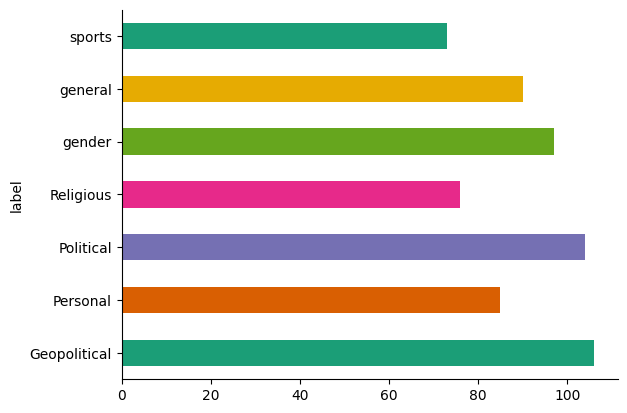

In [ ]:
test_data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

StopWord Removing

In [ ]:
def stopwordRemoval(text):
  x=str(text)
  l=x.split()

  stm=[elem for elem in l if elem not in stop]

  out=' '.join(stm)

  return str(out)

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/bangla_stopwords.xlsx')
display(data)

Unnamed: 0 word_list
0             0        ржЕржЗ
1             1    ржЕржЧрждрзНржпрж╛
2             2    ржЕржд: ржкрж░
3             3      ржЕрждржПржм
4             4       ржЕржержЪ
..          ...       ...
727         727      рж╣рзЯрзЗржЗ
728         728    рж╣рзЯрзЗржЫрж┐рж▓
729         729     рж╣рзЯрзЗржЫрзЗ
730         730    рж╣рзЯрзЗржЫрзЗржи
731         731       ржЕржВрж╢

[732 rows x 2 columns]

Stemming

In [ ]:
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer

In [ ]:
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [ ]:
train_data['text']=train_data['text'].apply(stem_text)
test_data['text']=test_data['text'].apply(stem_text)
validation_data['text']=validation_data['text'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied f

Labeling Numbers

In [ ]:
#changing label to numbers
train_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
test_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
validation_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)


<ipython-input-27-4ea1f1bb167c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
<ipython-input-27-4ea1f1bb167c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [ ]:
train_data.head()

text label  count
3806               ржмрзМржжрж┐ ржХрж╛рж░ рж╣рж╛ржд ржЫрзЛржБрзЯрж╛ рждрзЛржо ржУржЗ ржПржд ржмрзЬ рж╣рж▓рзЛ ?     4     10
8296   ржкрж╛ржкржи ржЬрзБрждрж╛ ржПрж░рзЗ ржзрж░рзЗ ржирж╛ ржХрзЗ ржмржЭ ржирж╛ ржПржЯрж╛ ржХрж┐ ржХрзНрж╖ржоржд ржжрж╛ржк...     6     15
9423              ржЬрзБрждрж╛ ржорж╛рж░рж┐ рждрж╛рж░ ржЧрж╛рж▓рзЗ ржкрж╛ржкржи рждрзЛ ржПржХ ржорж╛ржжрж╛ ржЪрзЛржж     6      9
15854  ржПржЗ ржирзБрж░рзБ рж╢рзБрзЯрж╛рж░ ржмрж╛ржЪрзНржЪрж╛ ржкрж╛ржЧрж▓ ржирж╛ржХрж┐ ржПржХрзЗржХ ржмрж╛рж░ ржПржХрзЗржХ ржХ...     3     11
9545   рждрж░ ржорж╛рзЯрзЗрж░ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ рждрж░ ржорж╛ржЗрж░рзЗ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛ...     6     29

In [ ]:
test_data.head()

text label  count
18649                                    ржжрзБржж ржЧрзБрж▓ ржжрж╛ржП ржХрж╛ржд     1      4
8928              ржорж╛ржЧрж┐рж░ ржкрзБрж▓рж╛ржорж╛рж▓ ржЦрж╛ржЗ ржЖржмрж╛рж▓ ржоржд ржнрзБрж▓ ржмрж╛рж▓ ржмржХрж┐рж╢     6      8
24242                                     ржорж╛ржЧрж┐рж░ ржжрзБржж ржЧрзБрж▓рж╛     1      3
20168  ржХрж┐ржЫрзБ ржЦрж╛ржиржЦрж┐ ржкрзЛрж▓рж╛ ржЦрж╛ржиржЦрзА ржорж╛ржЧрж┐рж░ ржХрж░ржирзЗ ржжрзЗрж╢ ржЯрж╛ ржЦрж╛рж░рж╛ржм ...     1     11
7609   ржнрж╛ржЗ рж╕рж░ржХ ржжрзЛрж╖ ржжрж┐ржм ржирж╛ рж╕рж░ржХрж╛рж░ ржХрж╛рж░ржгрзЗ ржЖржкржирж╛ ржПржЦржирзЛ ржорж╛рзЯ ржХ...     5     27

In [ ]:
train_data=train_data.dropna()
test_data=test_data.dropna()
validation_data=validation_data.dropna()

Counting Text Length

In [ ]:
#counting text length
train_data['count']=train_data['text'].str.split().str.len()
test_data['count']=test_data['text'].str.split().str.len()
validation_data['count']=validation_data['text'].str.split().str.len()

In [ ]:
train_sentences=train_data['text'].values
train_labels=train_data['label'].values

In [ ]:
test_sentences=test_data['text'].values
test_labels=test_data['label'].values

In [ ]:
validation_sentences=validation_data['text'].values
validation_labels=validation_data['label'].values

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical


num_classes = 7  # Set the number of classes to 7
# One-hot encode train_labels with 7 classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [ ]:
print("Training Set Length: "+str(len(train_data)))
print("Testing Set Length: "+str(len(test_data)))
print("Validation Set Length: "+str(len(validation_data)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 2200
Testing Set Length: 631
Validation Set Length: 312
train_labels shape: (2200, 7)
test_labels shape: (631, 7)
validation_labels shape: (312, 7)


In [ ]:
for sentence in train_sentences:
  print(sentence)

ржмрзМржжрж┐ ржХрж╛рж░ рж╣рж╛ржд ржЫрзЛржБрзЯрж╛ рждрзЛржо ржУржЗ ржПржд ржмрзЬ рж╣рж▓рзЛ ?
ржкрж╛ржкржи ржЬрзБрждрж╛ ржПрж░рзЗ ржзрж░рзЗ ржирж╛ ржХрзЗ ржмржЭ ржирж╛ ржПржЯрж╛ ржХрж┐ ржХрзНрж╖ржоржд ржжрж╛ржкржЯржУржХрзЗ ржХрзЗ ржЪрж┐ржирзЗ рж╕рж╛рж▓рж╛
ржЬрзБрждрж╛ ржорж╛рж░рж┐ рждрж╛рж░ ржЧрж╛рж▓рзЗ ржкрж╛ржкржи рждрзЛ ржПржХ ржорж╛ржжрж╛ ржЪрзЛржж
ржПржЗ ржирзБрж░рзБ рж╢рзБрзЯрж╛рж░ ржмрж╛ржЪрзНржЪрж╛ ржкрж╛ржЧрж▓ ржирж╛ржХрж┐ ржПржХрзЗржХ ржмрж╛рж░ ржПржХрзЗржХ ржХржерж╛ ржмрж▓рзЗ
рждрж░ ржорж╛рзЯрзЗрж░ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ рждрж░ ржорж╛ржЗрж░рзЗ рж╕рж╛рж▓рж╛ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░ ржЪрзЛрж░
ржкрж╛рж░рзЗ ржирж╛ ржХржерж╛ ржмрж▓ ржПрж░ ржЖржм ржЙржкрж╕рзНржерж╛ржкржирж╛ ржХрж░рзЗ
ржорж╛ржЧрзАрж░ ржХрж┐ ржПржЯрж┐ ржжрзБржз ржирж╛ ржЕржирзНржп ржХрж┐ржЫрзБ ржЪрж╛рж░ ржЬржи ржжрж╛ржЦ рж╣рж╛ржЯ ржлрж┐

Vocabulary Size and Maximum Sequence Length

In [ ]:
from collections import Counter

# Combine all sentences from train, test, and validation sets
all_sentences = train_sentences.tolist() + test_sentences.tolist() + validation_sentences.tolist()

# Tokenize all sentences
all_words = [word for sentence in all_sentences for word in sentence.split()]

# Count word frequencies
word_counts = Counter(all_words)

# Vocab size is the number of unique words
vocab_size = len(word_counts)

print(f"Vocab size: {vocab_size}")

Vocab size: 3577


In [ ]:
import numpy as np

# Combine all sentences from train, test, and validation sets
all_sentences = np.concatenate([train_sentences, test_sentences, validation_sentences])

# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in all_sentences]

# Calculate percentiles
percentile_95 = int(np.percentile(sentence_lengths, 95))
percentile_99 = int(np.percentile(sentence_lengths, 99))

print(f"95th percentile of sentence lengths: {percentile_95}")
print(f"99th percentile of sentence lengths: {percentile_99}")

# Choose max_length based on percentiles
max_length = percentile_95  # or percentile_99, depending on your preference
print(f"Chosen max_length: {max_length}")

95th percentile of sentence lengths: 40
99th percentile of sentence lengths: 81
Chosen max_length: 40


In [ ]:
vocab_size=3577
embedding_dim=64
max_length=40
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(2200,)
(2200, 7)


Tokenization

In [ ]:
#tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [ ]:
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))

3270
Word index length:3270


Padding

In [ ]:
from tensorflow.keras.utils import pad_sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (2200, 40)
Padded shape(testing): (631, 40)


In [ ]:
from tensorflow.keras.utils import pad_sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length:--> \n")
print(padded[2])

Sentence :--> 

ржЬрзБрждрж╛ ржорж╛рж░рж┐ рждрж╛рж░ ржЧрж╛рж▓рзЗ ржкрж╛ржкржи рждрзЛ ржПржХ ржорж╛ржжрж╛ ржЪрзЛржж

Sentence Tokenized and Converted into Sequence :--> 

[74, 340, 30, 277, 40, 14, 8, 83, 81]

After Padding the Sequence with padding length:--> 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  74 340  30 277  40
  14   8  83  81]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Model Training

In [ ]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.models import Sequential # Import the Sequential class
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
#l2 regularizer
model.add(Dense(16,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history=model.fit(padded,train_labels,epochs=10,batch_size=32,validation_data=( validation_padded,validation_labels))

Epoch 1/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 6s 28ms/step - accuracy: 0.2203 - loss: 2.1385 - val_accuracy: 0.1955 - val_loss: 2.0591
Epoch 2/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 2s 23ms/step - accuracy: 0.3917 - loss: 1.9588 - val_accuracy: 0.6122 - val_loss: 1.3562
Epoch 3/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 2s 23ms/step - accuracy: 0.7336 - loss: 1.1118 - val_accuracy: 0.8494 - val_loss: 0.7695
Epoch 4/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 2s 23ms/step - accuracy: 0.9069 - loss: 0.5119 - val_accuracy: 0.9135 - val_loss: 0.4571
Epoch 5/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 2s 23ms/step - accuracy: 0.9797 - loss: 0.2602 - val_accuracy: 0.9391 - val_loss: 0.4004
Epoch 6/10
69/69 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 2s 23ms/step - accuracy: 0.9911 - loss: 0.1945 - val_accuracy: 0.9263 - val_loss: 0.462

In [ ]:
model.summary()

Model: "sequential"

тФПтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФ│тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФ│тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФУ
тФГ Layer (type)                         тФГ Output Shape                тФГ         Param # тФГ
тФбтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтХЗтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтХЗтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФй
тФВ embedding (Embedding)                тФВ (None, 40, 64)              тФВ         228,928 тФВ
тФЬтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФд
тФВ bidirectional (Bidirectional)        тФВ (None, 40, 32)              тФВ          10,368 тФВ
тФЬтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФд
тФВ dense (Dense)                        тФВ (None, 40, 16)              тФВ             528 тФВ
тФЬтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФд
тФВ flatten (Flatten)                    тФВ (None, 640)                 тФВ               0 тФВ
тФЬтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ╝тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФд
тФВ dense_1 (Dense)                      тФВ (None, 7)                   тФВ           4,487 тФВ
тФФтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ┤тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФ┤тФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФАтФШ

 Total params: 732,935 (2.80 MB)

 Trainable params: 244,311 (954.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 488,624 (1.86 MB)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


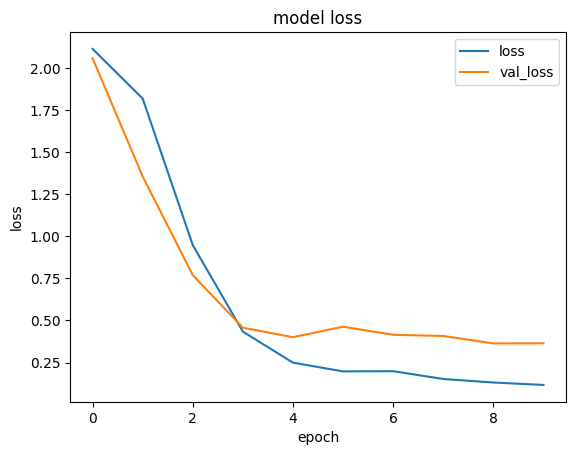

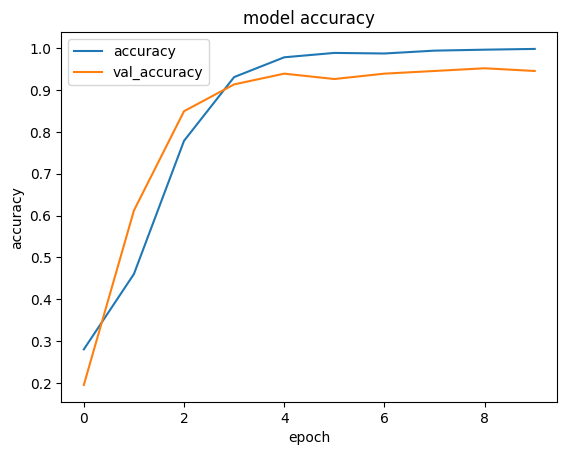

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))

35/35 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 0s 7ms/step - accuracy: 0.9965 - loss: 0.1118
The train accuracy is: 0.9968181848526001
10/10 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 0s 8ms/step - accuracy: 0.9247 - loss: 0.4784
The test accuracy is: 0.9397781491279602


20/20 тФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБтФБ 0s 6ms/step


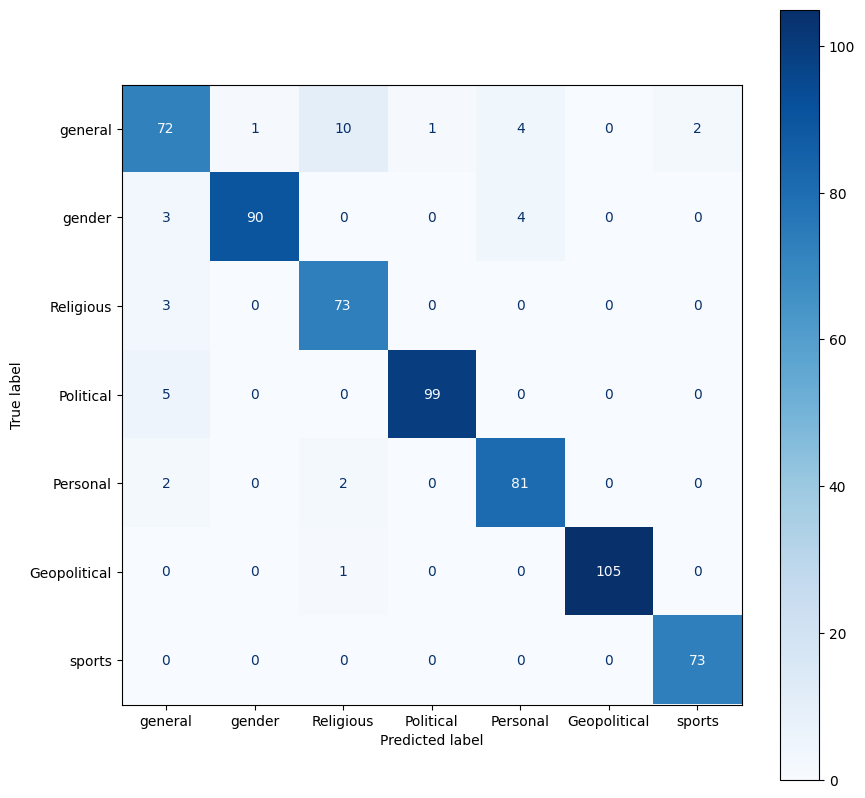

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np



# Predict on the test data
y_pred = model.predict(testing_padded)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize as needed



disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['general','gender','Religious','Political','Personal','Geopolitical','sports'])

# Pass the axes to the plot method
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
# Print classification report with precision, recall, F1-score
print(classification_report(true_classes, predicted_classes, target_names=['general','gender','Religious','Political','Personal','Geopolitical','sports']))

              precision    recall  f1-score   support

     general       0.85      0.80      0.82        90
      gender       0.99      0.93      0.96        97
   Religious       0.85      0.96      0.90        76
   Political       0.99      0.95      0.97       104
    Personal       0.91      0.95      0.93        85
Geopolitical       1.00      0.99      1.00       106
      sports       0.97      1.00      0.99        73

    accuracy                           0.94       631
   macro avg       0.94      0.94      0.94       631
weighted avg       0.94      0.94      0.94       631

